In [2]:
import numpy as np
import pandas as pd
import nltk
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

import paralleldots

import re
import datetime

import seaborn as sns
sns.set()
sns.set_style('white')

[nltk_data] Downloading package punkt to /Users/cwagen/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/cwagen/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


11794 tweets in database
9073 original tweets in database

sources:
    Twitter for iPhone           11224 rows
    Twitter Media Studio           118 rows
    Twitter Web App                  4 rows
    Twitter Web Client              48 rows
    Twitter for iPad                38 rows
    Media Studio                   155 rows
    Twitter Ads                     33 rows
    Twitter for Android            174 rows


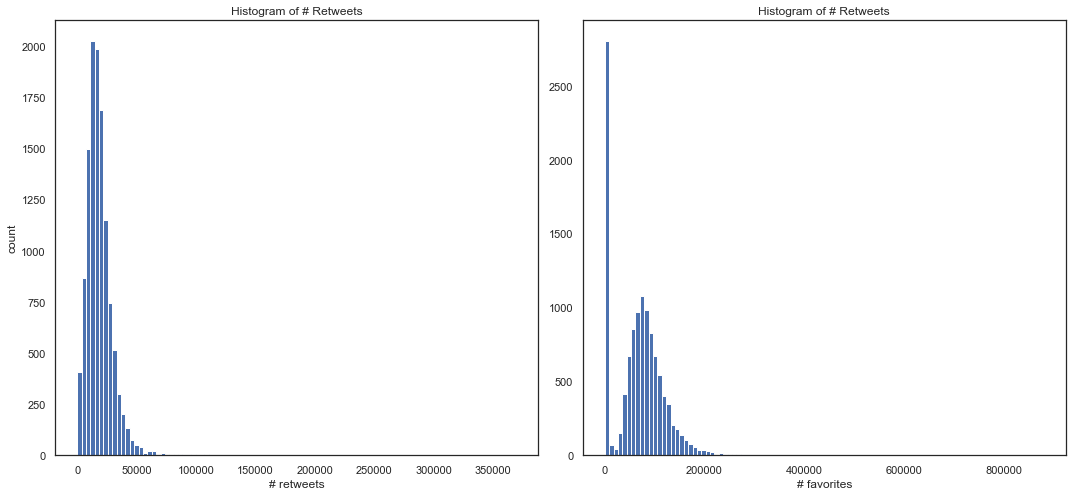

               source                                               text  \
0  Twitter for iPhone  RT @GOPoversight: Days since @RepAdamSchiff le...   
1  Twitter for iPhone  RT @RepMattGaetz: MUST-READ: "Gaetz: 'Donald T...   
2  Twitter for iPhone  RT @RepDougCollins: Adam Schiff wants to impea...   
3  Twitter for iPhone  RT @RepGregPence: After seven weeks of running...   
4  Twitter for iPhone  RT @RepJeffDuncan: Now Pelosi &amp; Schiff wan...   

            created_at  retweet_count  favorite_count is_retweet  \
0  10-30-2019 03:09:07           5818               0       True   
1  10-30-2019 03:09:05           8236               0       True   
2  10-30-2019 03:08:59           9495               0       True   
3  10-30-2019 03:08:54           7861               0       True   
4  10-30-2019 03:08:50           7280               0       True   

                id_str  
0  1189378671326515200  
1  1189378663646711808  
2  1189378636803129344  
3  1189378618838925312  
4  118937

In [3]:
raw_tweets = pd.read_csv('raw_tweets.csv')
print(f"{len(raw_tweets)} tweets in database")
print(f"{len(raw_tweets.loc[raw_tweets.is_retweet == False])} original tweets in database")

print('')
print("sources:")
for source in (raw_tweets.source.unique()):
    count = len(raw_tweets.loc[raw_tweets.source == source])
    print(f"    {source:25s} {count:>8d} rows")
    
fig, axes = plt.subplots(ncols=2,figsize=(15,7))
axes[0].hist(raw_tweets.retweet_count, bins=100)
axes[1].hist(raw_tweets.favorite_count, bins=100)
axes[0].set_title('Histogram of # Retweets')
axes[1].set_title('Histogram of # Retweets')
axes[0].set_ylabel('count')
axes[0].set_xlabel('# retweets')
axes[1].set_xlabel('# favorites')
plt.tight_layout()
plt.show()
print(raw_tweets.head())

In [3]:
keywords_by_topic = {}
keywords_by_topic['China'] = ["China", "Xi", "Jinping", "Hong Kong", "Beijing", "Shanghai", "Chinese", "Taiwan"]
keywords_by_topic['Russia'] = ["Vladimir", "Putin", "Russia", "Moscow", "Soviet", "Siberia", "Russian"]
keywords_by_topic['Mexico'] = ["Mexico", "Border", "immigrants", "mexican", "Wall", "Obrador", "Mexican", "DACA", "WALL", "border"]
keywords_by_topic['Canada'] = ["Canada", "Quebec", "Toronto", "Montreal", "Ottawa", "JustinTrudeau", "Trudeau"]
keywords_by_topic['Korea'] = ["Korea", "Kim", "Rodman", "Pyongyang", "Seoul", "Korean"]
keywords_by_topic['Clinton'] = ["Hillary", "Clinton", "Bill", "Crooked", "Watergate", "Arkansas"]
keywords_by_topic['Democrats'] = ["Dems", "Democrats", "Nancy", "SpeakerPelosi", "Left", "Leftist", "Socialist", "Socialism", "Pelosi", "Democrat", "Democratic", "democratics", "democrat", "DNC", "Schumer", "Libs", "Liberal", "Liberals"]
keywords_by_topic['Republicans'] = ["GOP", "Republicans", "REPUBLICANS", "Right", "republicans", "Republican", "republican", "McConnell", "GOPChairwoman", "RNC", "VP", "Pence"]
keywords_by_topic['himself'] = ['Donald', 'Trump', 'POTUS', 'MAGA', 'realDonaldTrump', 'WhiteHouse', 'President', 'MAKE', 'AMERICA', 'GREAT', 'AGAIN', "Great", "HouseGOP"]
keywords_by_topic['family'] = ["FLOTUS", "Melania", "Ivanka", "Don", "IvankaTrump", "DonaldJTrumpJr"]
keywords_by_topic['government'] = ["Senate", "Congress", "USA", "U.S.", "United", "America", "States", "Country", "State", 'country', "Washington"]
keywords_by_topic['media'] = ["Fox", "CNN", "News", "news", "media", "Media", "foxandfriends", "FoxNews", "Fake", 'fake', "NEWS", "FAKE"]
keywords_by_topic['states'] = ["California", "Texas", "Florida", "Virginia", "Iowa", "Hampshire", "Carolina", "Oregon", "Dakota", "Utah", "Pennsylvania", "Oklahoma", "Nevada", "Arizona", "Montana", "Idaho", "Nebraska", "Michigan", "Illinois", "Indiana", "Ohio", "Vermont", "Maine", "York", "Tennessee", "Mississippi", "Louisiana", "Alabama", "Georgia", "Delaware"]
keywords_by_topic['social_media'] = ["Twitter", "Facebook", "Zuckerberg", "Dorsey"]
keywords_by_topic['Obama'] = ["Barack", "Obama", "ObamaCare"]
keywords_by_topic['FBI'] = ["FBI", "Comey", "Mueller", "DOJ"]
keywords_by_topic['rivals'] = ["Warren", "Bernie", "Sanders", "Biden", "Pete", "Buttegieg", "Beto", "O'Rourke", "Klobuchar", "Kamala", "Harris", "KamalaHarris"]
keywords_by_topic['MiddleEast'] = ["ISIS", "Syria", "Yemen", "Iran", "Saudi", "Arabia", "Iraq", "Afghanistan", "Lebanon", "Israel", "Assad", "Ayatollah", "Palestine", "Turkey", "Abu", "al-Baghdadi", "Kurd", "Kurds"]
keywords_by_topic['Ukraine_scandal'] = ["Ukraine", "Zelensky", "Schiff", "RepAdamSchiff", "impeach", "impeachment", "whistleblower", "Whistleblower", "transcript", "Transcript", "TRANSCRIPT"]
keywords_by_topic['economy'] = ['economy', "Economy","Economic", "JOBS", "jobs", "tax", "taxation", "Tax", "taxes", "growth", "money", "dollars", "Dollars", "companies"]
keywords_by_topic['disaster'] = ["FEMA", "disaster", "Hurricane", "hurricane"]

In [4]:
def does_tweet_mention_topic (topic, words):
    for word in words:
        if word in keywords_by_topic[topic]:
            return True
    return False

In [4]:
tweet_predictors = pd.DataFrame()

hashtag_re = re.compile("#")
mentions_re = re.compile("@")

total_text = pd.DataFrame(columns=['word', 'pos'])

for index, tweet in raw_tweets.iterrows():
    tweet_text = tweet['text']
    words = tweet_text.split()
    
    clean_text = tweet_text.replace("RT", "Retweet")
    clean_text = clean_text.replace("@", '')
    clean_text = clean_text.replace("#", '')
    clean_text = clean_text.replace("&amp;", '&')
    clean_text = re.sub(r'https:\/\/t.co.*$', '', clean_text)

    tweet_predictors.loc[index, 'clean_text'] = clean_text

#print(len(total_text))
#print(tweet_predictors.iloc[0:500].loc[tweet_predictors['num_hashtags'] > 0])
print(tweet_predictors.head())

                                          clean_text
0  Retweet GOPoversight: Days since RepAdamSchiff...
1  Retweet RepMattGaetz: MUST-READ: "Gaetz: 'Dona...
2  Retweet RepDougCollins: Adam Schiff wants to i...
3  Retweet RepGregPence: After seven weeks of run...
4  Retweet RepJeffDuncan: Now Pelosi & Schiff wan...


In [9]:
total_text.to_csv('nlp_parsed_words')

In [5]:
tweet_predictors.to_csv('cleaned_tweet_text')

In [6]:
tweet_predictors2 = pd.read_csv('cleaned_tweet_text')

for index, tweet in raw_tweets.iterrows():
    created_day = tweet['created_at']
    created_dt = datetime.datetime.strptime(created_day, "%m-%d-%Y %H:%M:%S")

    tweet_predictors2.loc[index, 'year'] = created_dt.year
    tweet_predictors2.loc[index, 'month'] = created_dt.month
    tweet_predictors2.loc[index, 'day'] = created_dt.day
    tweet_predictors2.loc[index, 'hour'] = created_dt.hour
    tweet_predictors2.loc[index, 'minute'] = created_dt.minute


In [7]:
tweet_predictors2.to_csv('cleaned_tweets_text')
print(tweet_predictors2.head())

   Unnamed: 0                                         clean_text    year  \
0           0  Retweet GOPoversight: Days since RepAdamSchiff...  2019.0   
1           1  Retweet RepMattGaetz: MUST-READ: "Gaetz: 'Dona...  2019.0   
2           2  Retweet RepDougCollins: Adam Schiff wants to i...  2019.0   
3           3  Retweet RepGregPence: After seven weeks of run...  2019.0   
4           4  Retweet RepJeffDuncan: Now Pelosi & Schiff wan...  2019.0   

   month   day  hour  minute  
0   10.0  30.0   3.0     9.0  
1   10.0  30.0   3.0     9.0  
2   10.0  30.0   3.0     8.0  
3   10.0  30.0   3.0     8.0  
4   10.0  30.0   3.0     8.0  
